In [1]:
#Library

import pandas as pd 
import numpy as np

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.tuning import random_search_params as rsp, bayes_search_params as bsp, grid_search_params as gsp
from jcopml.tuning.space import Integer, Real

import warnings
warnings.filterwarnings("ignore")

sw_indo = stopwords.words("indonesian") + list(punctuation)

# Import Data

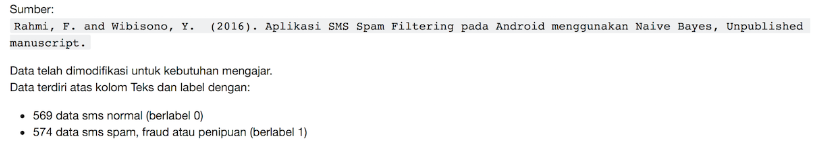

In [3]:
df = pd.read_csv("data/spam.csv")
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


# Dataset Splitting

In [4]:
X = df.Teks
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y) # not for regression
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((914,), (229,), (914,), (229,))

# Training

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
#Modeling & Hyperparameter Tuning

from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

parameter = {
    'algo__fit_intercept': [True, False],
    'algo__C': Real(low=-3, high=3, prior='log-uniform')
}

model = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)


print(
f"""

MODEL BEST PARAMETER : {model.best_params_}
MODEL TRAINING SCORE : {model.score(X_train, y_train)}
MODEL BEST SCORE     : {model.best_score_}
MODEL TEST SCORE     : {model.score(X_test, y_test)}

"""
)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/baihaqi/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/baihaqi/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/baihaqi/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/baihaqi/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(




MODEL BEST PARAMETER : {'algo__C': 18.851284341010228, 'algo__fit_intercept': True}
MODEL TRAINING SCORE : 1.0
MODEL BEST SCORE     : 0.96388769053782
MODEL TEST SCORE     : 0.9781659388646288




# Save Model

In [8]:
import pickle

with open('model/model_sms_classification.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully.")

Model saved successfully.


# Sanity Check

In [ ]:
# SVC(probability=True) # kalau model SVC by default proba nya mati

In [9]:
text=["Sayng belikan aq pulsa di nmr ini, 085215126428, nanti aq yg tlpn km, nini aq pke ghp tmn, skrng yacc!"]
model.predict(text), model.predict_proba(text) # probability 39% normal, 60% spam

(array([1]), array([[0.18384403, 0.81615597]]))

In [10]:
text=["Saya sudah sampai didepan rumah ya pak!"]
model.predict(text), model.predict_proba(text)

(array([0]), array([[0.90541318, 0.09458682]]))

In [11]:
text=["""TUTUP CC & KTA ANDA, KAMI BANTU DENGAN 2 SOLUSI: 
1.CICIL TETAP BUNGA 0%
2. DISC PELUNASAN 30% S/D 60%
CLEAR BI & LEGAL 

INFO: 
TELP/WA: MEGA 0813 1301 0131"""]
model.predict(text), model.predict_proba(text)

(array([1]), array([[0.18032032, 0.81967968]]))

In [12]:
text=["Not spam!! DAPATKAN DISKON LAZADA DI HARI ESOK!!"]
model.predict(text), model.predict_proba(text)

(array([1]), array([[0.30760881, 0.69239119]]))